# Version information

In [1]:
from datetime import date
print("Running date:", date.today().strftime("%B %d, %Y"))
import pyleecan
print("Pyleecan version:" + pyleecan.__version__)
import SciDataTool
print("SciDataTool version:" + SciDataTool.__version__)

Running date: November 26, 2021
Pyleecan version:1.3.7
SciDataTool version:1.4.22


# Classes Glossary
This tutorials mainly uses the following classes:

- [VarParam](https://pyleecan.org/pyleecan.Classes.VarParam.html): Class to define a multisimulation by varying parameters
- [VarLoadCurrent](https://pyleecan.org/pyleecan.Classes.VarLoadCurrent.html): Class to define a multisimulation by varying operating point
- [DataKeeper](https://pyleecan.org/pyleecan.Classes.DataKeeper.html): Class to select some data to keep from a multi-simulation
- [ParamExplorerInterval](https://pyleecan.org/pyleecan.Classes.ParamExplorerInterval.html): Class to define a design variable (for parameter sweep) with value on an interval
- [ParamExplorerSet](https://pyleecan.org/pyleecan.Classes.ParamExplorerSet.html): Class to define a design variable (for parameter sweep) with value from a set
- [Output](https://pyleecan.org/pyleecan.Classes.Output.html): Class to  gather all the outputs of all the modules
- [XOutput](https://pyleecan.org/pyleecan.Classes.XOutput.html): Class to gathers all the outputs of all the modules for multiple simulations


# How to define a Parameter Sweep of a Variable speed simulation?
This tutorial explains how to use the objects VarParam and VarLoadCurrent to run Parameter Sweep of a Variable speed simulation by using the multi-simulation tools of pyleecan. This tutorial combines several advanced aspect of pyleecan, please read the following tutorials first:

- "[How to define a machine](https://pyleecan.org/tuto_Machine.html)"
- "[How to define a simulation to call FEMM](https://pyleecan.org/tuto_Simulation_FEMM.html)".
- "[How to set the Operating Point](https://pyleecan.org/tuto_Operating_point.html)".
- "[How to run a multi-simulation](https://pyleecan.org/tuto_multisimulation.html)".

The multi-simulation tools of Pyleecan can be combined to create multi-simulation of multi-simulation. This tutorial will build step by step (or layer by layer) a parameter sweep to study the impact of the stator slot opening of the Toyota Prius on the variable speed torque. 

## Machine and Reference Simulation definition
The first step is to define the reference simulation aka the original machine without any modifications from the VarParam (Parameter sweep object) nor the VarLoadCurrent (Variable speed object). This tutorial uses the usual machine Toyota Prius (2004) and simulation from the previous tutorials:

<IPython.core.display.Javascript object>


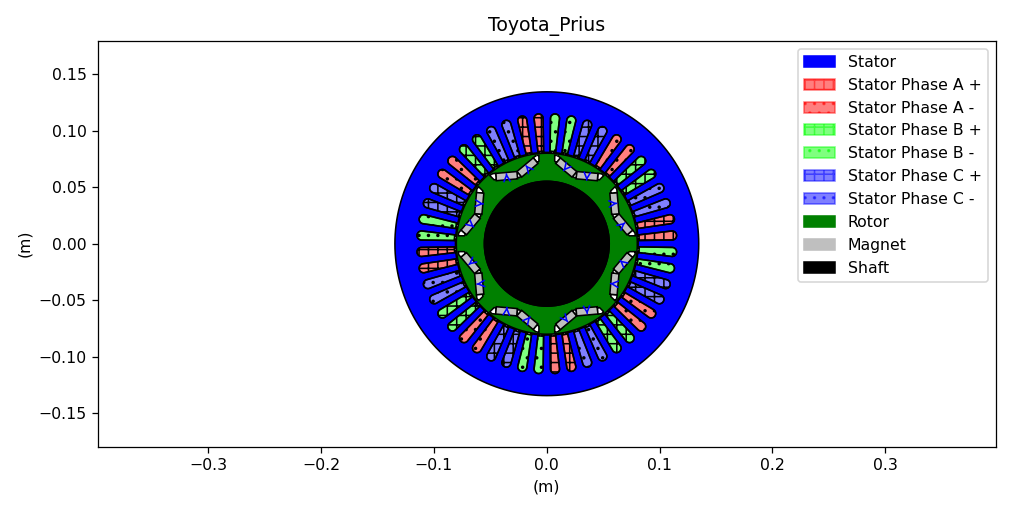

In [2]:
%matplotlib notebook

# Load the machine
from pyleecan.Functions.load import load
from pyleecan.definitions import DATA_DIR
from os.path import join

Toyota_Prius = load(join(DATA_DIR, "Machine", "Toyota_Prius.json"))
Toyota_Prius.plot()

In [6]:
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.MagFEMM import MagFEMM
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.Classes.OPdq import OPdq
from numpy import sqrt, pi
# Initialization of the Simulation
simu_ref = Simu1(name="tuto_multi", machine=Toyota_Prius)

# Definition of the magnetic simulation (FEMM with symmetry and sliding band)
simu_ref.mag = MagFEMM(
    type_BH_stator=0,
    type_BH_rotor=0,
    is_periodicity_a=True,
    is_periodicity_t=True,
    nb_worker=4,
    Kgeo_fineness=1,
)
# Run only Magnetic module
simu_ref.elec = None
simu_ref.force = None
simu_ref.struct = None

simu_ref.input = InputCurrent()
simu_ref.input.Nt_tot = 128 # Number of time step
simu_ref.input.Na_tot = 2048 # Spatial discretization
# Set reference simulation operating point
simu_ref.input.OP = OPdq(N0 = 2000) # Rotor speed [rpm]
simu_ref.input.OP.Tem_av_ref = 353
simu_ref.input.OP.set_I0_Phi0(I0=250/sqrt(2), Phi0=140*pi/180)

The reference simulation "simu_ref" is now fully defined. 
It can be run before the multi-simulation to make sure that everything is correctly defined. 

The multi-simulation will copy/update the reference simulation and its results. Thus, only the minimum input/output should be modified to save memory and computation time.

The reference simulation outputs are used for comparison purpose. 

In [7]:
output_ref = simu_ref.run()

[16:41:45] Starting running simulation tuto_multi (machine=Toyota_Prius)
[16:41:45] Starting Magnetic module
[16:41:48] Solving time step 1 / 16 in FEMM
[16:41:49] Solving time step 9 / 16 in FEMM
[16:41:49] Solving time step 5 / 16 in FEMM
[16:41:50] Solving time step 13 / 16 in FEMM
[16:41:51] Solving time step 2 / 16 in FEMM
[16:41:53] Solving time step 10 / 16 in FEMM
[16:41:53] Solving time step 6 / 16 in FEMM
[16:41:54] Solving time step 3 / 16 in FEMM
[16:41:55] Solving time step 14 / 16 in FEMM
[16:41:57] Solving time step 11 / 16 in FEMM
[16:41:57] Solving time step 7 / 16 in FEMM
[16:41:58] Solving time step 4 / 16 in FEMM
[16:42:00] Solving time step 8 / 16 in FEMM
[16:42:00] Solving time step 15 / 16 in FEMM
[16:42:00] Solving time step 12 / 16 in FEMM
[16:42:03] Solving time step 16 / 16 in FEMM
[16:42:05] End of simulation tuto_multi


In this tutorial we will focus on the main magnetic outputs. For example, after the reference simulation:

<IPython.core.display.Javascript object>


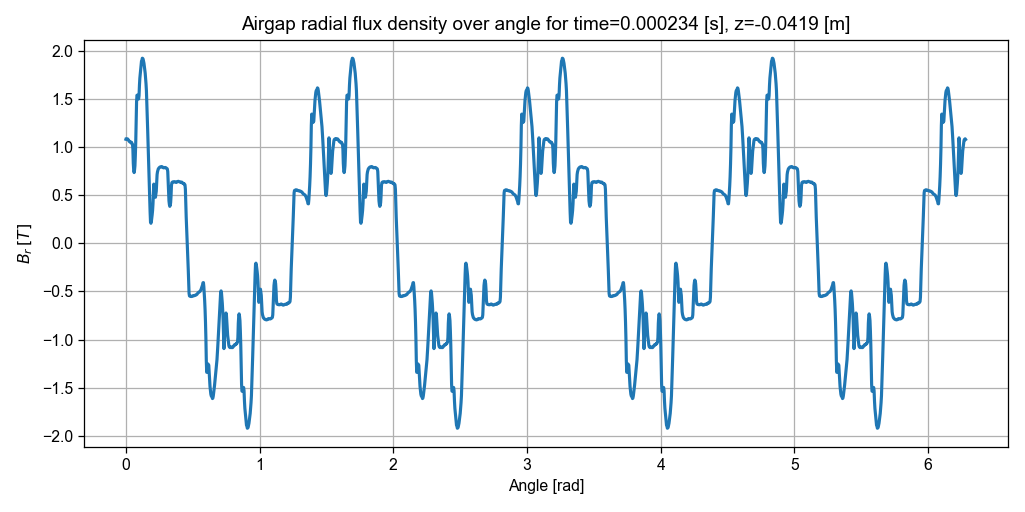

<IPython.core.display.Javascript object>


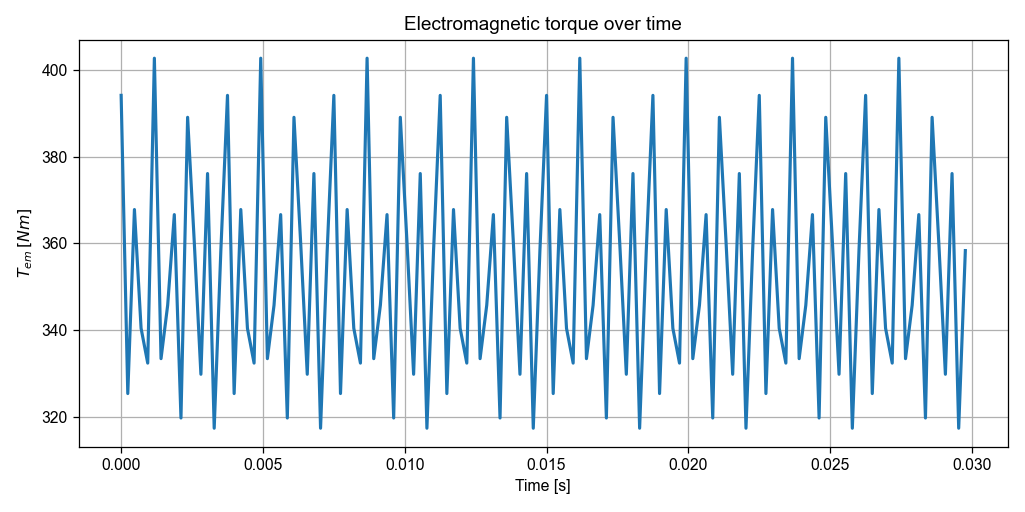

Main torque Output:
Average Electromagnetic torque [N.m]:353.6879347693815
Peak to Peak Torque ripple [N.m]:85.39952606627293
Peak to Peak Torque ripple normalized according to average torque [-]:0.24145445086204817
Torque values (with symmetry):
[394.14438979 325.31895614 367.79221479 340.38661417 332.34562852
 402.71573024 333.37066243 345.71271835 366.62085138 319.67355885
 389.08028079 360.34653031 329.76753327 376.10009538 317.31620417
 358.31498773]

Operating Point:
Rotor speed [rpm]:2000
Id [Arms]:-135.4188051049254
Iq [Arms]:113.62986941801093


In [9]:
# Flux
output_ref.mag.B.plot_2D_Data("angle","time[1]",component_list=["radial"])

# Torque
output_ref.mag.Tem.plot_2D_Data("time")
print("Main torque Output:")
print("Average Electromagnetic torque [N.m]:" +str(output_ref.mag.Tem_av))
print("Peak to Peak Torque ripple [N.m]:" +str(output_ref.mag.Tem_rip_pp))
print("Peak to Peak Torque ripple normalized according to average torque [-]:" +str(output_ref.mag.Tem_rip_norm))
print("Torque values (with symmetry):\n"+str(output_ref.mag.Tem.values))

# Operating point
print("\nOperating Point:")
print("Rotor speed [rpm]:"+str(output_ref.elec.OP.N0))
print("Id [Arms]:"+str(output_ref.elec.OP.Id_ref))
print("Iq [Arms]:"+str(output_ref.elec.OP.Iq_ref))

Although the operation point was defined with I0/Phi0, pyleecan store and use only Id/Iq.

## First multi-simulation layer: Variable speed

The next step is to define the variable speed simulation. This tutorial uses the results from: 
Z. Yang, M. Krishnamurthy and I. P. Brown, “Electromagnetic and vibrational characteristic of IPM over full torque-speed range,” 2013 International Electric Machines & Drives Conference, Chicago, IL, 2013, pp. 295-302, doi: 10.1109/IEMDC.2013.6556267.

Each pyleecan simulation is assumed to be quasi-static and run on a single operating point (fixed speed). To run a simulation on several operating points two steps are needed: 
- First define a simulation that run correctly on a single operating point (like the one defined above), 
- then define a VarLoadCurrent object. 

The VarLoadCurrent object is defined with a matrix where each line corresponds to an operating point and the column are:
- (N0, I0, Phi0) if type_OP_matrix==0
- (N0, Id, Iq) if type_OP_matrix==1

The following VarLoadCurrent object will run the previous simulation N_speed times by changing the value of Phi0. 

A fourth column can be added by setting is_torque=True. It enables to define the reference torque for the Operating Point. The reference torque is stored in output.elec.Tem_av_ref, the real computed torque is stored in output.mag.Tem_av.

Reference torque and current angle vector are:

In [10]:
from numpy import linspace, array, pi

Tem_av_ref = array([79, 125, 160, 192, 237, 281, 319, 343, 353, 332, 266, 164, 22]) # Yang et al, 2013
Phi0_ref = linspace(60 * pi / 180, 180 * pi / 180, Tem_av_ref.size)
N_speed = Tem_av_ref.size

In [11]:
from pyleecan.Classes.VarLoadCurrent import VarLoadCurrent
from numpy import zeros, ones, linspace, array, sqrt, arange

varload = VarLoadCurrent(is_torque=True)
varload.type_OP_matrix = 0 # Matrix N0, I0, Phi0

# Creating the Operating point matrix
OP_matrix = zeros((N_speed,4))

# Set N0 = 2000 [rpm] for all simulation
OP_matrix[:,0] = 2000 * ones((N_speed))

# Set I0 = 250 / sqrt(2) [A] (RMS) for all simulation
OP_matrix[:,1] = 250/sqrt(2) * ones((N_speed)) 

# Set Phi0 from 60° to 180°
OP_matrix[:,2] = Phi0_ref

# Set reference torque from Yang et al, 2013
OP_matrix[:,3] = Tem_av_ref

varload.OP_matrix = OP_matrix
print(OP_matrix)

# All the simulation use the same machine
# No need to draw the machine for all OP
varload.is_reuse_femm_file=True  

[[2.00000000e+03 1.76776695e+02 1.04719755e+00 7.90000000e+01]
 [2.00000000e+03 1.76776695e+02 1.22173048e+00 1.25000000e+02]
 [2.00000000e+03 1.76776695e+02 1.39626340e+00 1.60000000e+02]
 [2.00000000e+03 1.76776695e+02 1.57079633e+00 1.92000000e+02]
 [2.00000000e+03 1.76776695e+02 1.74532925e+00 2.37000000e+02]
 [2.00000000e+03 1.76776695e+02 1.91986218e+00 2.81000000e+02]
 [2.00000000e+03 1.76776695e+02 2.09439510e+00 3.19000000e+02]
 [2.00000000e+03 1.76776695e+02 2.26892803e+00 3.43000000e+02]
 [2.00000000e+03 1.76776695e+02 2.44346095e+00 3.53000000e+02]
 [2.00000000e+03 1.76776695e+02 2.61799388e+00 3.32000000e+02]
 [2.00000000e+03 1.76776695e+02 2.79252680e+00 2.66000000e+02]
 [2.00000000e+03 1.76776695e+02 2.96705973e+00 1.64000000e+02]
 [2.00000000e+03 1.76776695e+02 3.14159265e+00 2.20000000e+01]]


This first layer will behave as follow:
- First the reference simulation will be run to get the reference output,
- then the reference simulation will be duplicated N_speed times with the value of InputCurrent updated according to the OP matrix. 
- is_reuse_femm will update the N_speed simulations to reuse the FEMM file drawn in the reference simulation to speed-up the computations.
- Each simulation of the list will be run separately and the results gathered in an XOutput object.

Pyleecan can detect that a simulation from the list matches the reference one and skip its computation to avoid computing twice the same thing. When defining a multi-simulation of multi-simulation, this optimization is essential since pyleecan will run "1 + (N_speed-1)" simulations instead of "1 + N_speed" for each combinaison of the design parameters. 

To further understand pyleecan multi-simulation tools, this tutorial uses the option "is_keep_all_output" that keeps all the output of all the simulations. This option enables to access the plot for all the Operating Points but can take significant memory space depending on the simulation.

In [12]:
simu_vop = simu_ref.copy()
simu_vop.var_simu = varload
simu_vop.var_simu.is_keep_all_output = True

# Speed-up computation (set reference simu input as first OP), here reference is already the 9th simulation
# simu_vop.input.set_OP_from_array(varload.OP_matrix, varload.type_OP_matrix)

In [13]:
Xout_vop = simu_vop.run()

[16:43:31] Starting running simulation tuto_multi (machine=Toyota_Prius)
[16:43:31] Reference Operating point is not in OP_matrix, one extra simulation will be computed
[16:43:31] Computing reference simulation for Variable Load
[16:43:31] Starting Magnetic module
[16:43:34] Solving time step 1 / 16 in FEMM
[16:43:35] Solving time step 5 / 16 in FEMM
[16:43:35] Solving time step 9 / 16 in FEMM
[16:43:36] Solving time step 13 / 16 in FEMM
[16:43:37] Solving time step 2 / 16 in FEMM
[16:43:39] Solving time step 6 / 16 in FEMM
[16:43:40] Solving time step 14 / 16 in FEMM
[16:43:41] Solving time step 10 / 16 in FEMM
[16:43:41] Solving time step 3 / 16 in FEMM
[16:43:42] Solving time step 7 / 16 in FEMM
[16:43:42] Solving time step 15 / 16 in FEMM
[16:43:44] Solving time step 11 / 16 in FEMM
[16:43:44] Solving time step 4 / 16 in FEMM
[16:43:45] Solving time step 16 / 16 in FEMM
[16:43:46] Solving time step 8 / 16 in FEMM
[16:43:47] Solving time step 12 / 16 in FEMM
[16:43:51] Variable Load

[16:45:33] Starting Magnetic module
[16:45:33] Solving time step 9 / 16 in FEMM
[16:45:34] Solving time step 1 / 16 in FEMM
[16:45:35] Solving time step 5 / 16 in FEMM
[16:45:35] Solving time step 13 / 16 in FEMM
[16:45:36] Solving time step 10 / 16 in FEMM
[16:45:38] Solving time step 2 / 16 in FEMM
[16:45:38] Solving time step 6 / 16 in FEMM
[16:45:39] Solving time step 14 / 16 in FEMM
[16:45:40] Solving time step 11 / 16 in FEMM
[16:45:41] Solving time step 7 / 16 in FEMM
[16:45:41] Solving time step 3 / 16 in FEMM
[16:45:41] Solving time step 15 / 16 in FEMM
[16:45:43] Solving time step 12 / 16 in FEMM
[16:45:44] Solving time step 8 / 16 in FEMM
[16:45:44] Solving time step 4 / 16 in FEMM
[16:45:44] Solving time step 16 / 16 in FEMM
[16:45:48] Variable Load Results: N0=2000 [rpm], Id=-88.39 [Arms], Iq=153.1 [Arms], I0=176.8 [A], Phi0=2.094 [], Tem_av_ref=None [N.m], Tem_av=323.8 [N.m], Tem_rip_pp=80.18 [N.m], Tem_rip_norm=0.2476 [-], Pem_av=6.782e+04 [W]
[==========================

The log of the simulation enables to understand step by step the status of the computation. As expected, the reference simulation is computed first. Then each of the 13 simulations is run starting with a message indicating the simulation operating point:

**Running simulation 3/13 with N0=2000 [rpm], Id=30.7 [Arms], Iq=174.1 [Arms]**

And ending with the Datakeepers result for this simulation:

**Variable Load Results: N0=2000 [rpm], Id=30.7 [Arms], Iq=174.1 [Arms], I0=176.8 [A], Phi0=1.396 [], Tem_av_ref=160 [N.m], Tem_av=170.3 [N.m], Tem_rip_pp=53.12 [N.m], Tem_rip_norm=0.312 [-]**

As expected the computation for the 9th simulation was skipped, the operating point and Datakeepers are still displayed as a reminder.

Pyleecan will automatically defines several Datakeeper to extract the main outputs from each simulation. These values are all gathered in the xoutput_dict:

In [14]:
print("Values available in XOutput:")
print(Xout_vop.xoutput_dict.keys())

print("\nI0 for each simulation:")
print(Xout_vop["I0"].result)
print("\nPhi0 for each simulation:")
print(Xout_vop["Phi0"].result)
print("\nComputed Average Torque for each simulation:")
print(Xout_vop["Tem_av"].result)
print("\nComputed Average Torque of the reference simulation:")
print(Xout_vop["Tem_av"].result_ref)

Values available in XOutput:
dict_keys(['N0', 'Id', 'Iq', 'I0', 'Phi0', 'Tem_av_ref', 'Tem_av', 'Tem_rip_pp', 'Tem_rip_norm', 'Pem_av'])

I0 for each simulation:
[176.77669529663686, 176.77669529663686, 176.77669529663683, 176.77669529663686, 176.77669529663683, 176.77669529663686, 176.77669529663686, 176.77669529663686, 176.77669529663686, 176.77669529663686, 176.77669529663683, 176.77669529663683, 176.77669529663686]

Phi0 for each simulation:
[1.0471975511965976, 1.2217304763960306, 1.3962634015954636, 1.5707963267948966, 1.7453292519943295, 1.9198621771937625, 2.0943951023931957, 2.2689280275926285, 2.443460952792061, 2.6179938779914944, 2.7925268031909276, 2.9670597283903604, 3.141592653589793]

Computed Average Torque for each simulation:
[82.70058164915343, 126.4346038801843, 171.2892053139925, 215.28492689188755, 256.53629126712804, 293.3305925751831, 323.82251465312413, 345.44714301730926, 353.6879347693815, 336.9703399930378, 270.5958441929039, 151.26679496425805, -5.31435637

Other Datakeeper can be added in simu.var_simu.datakeeper_list to extract other meaningful (or user-defined) data.

As the option is_keep_all_output was activated, one can also access all the simulation results in the "output_list":

Id: 30.69695099224322 , Iq: 174.0910600800047 , Tem_av_ref: None


<IPython.core.display.Javascript object>


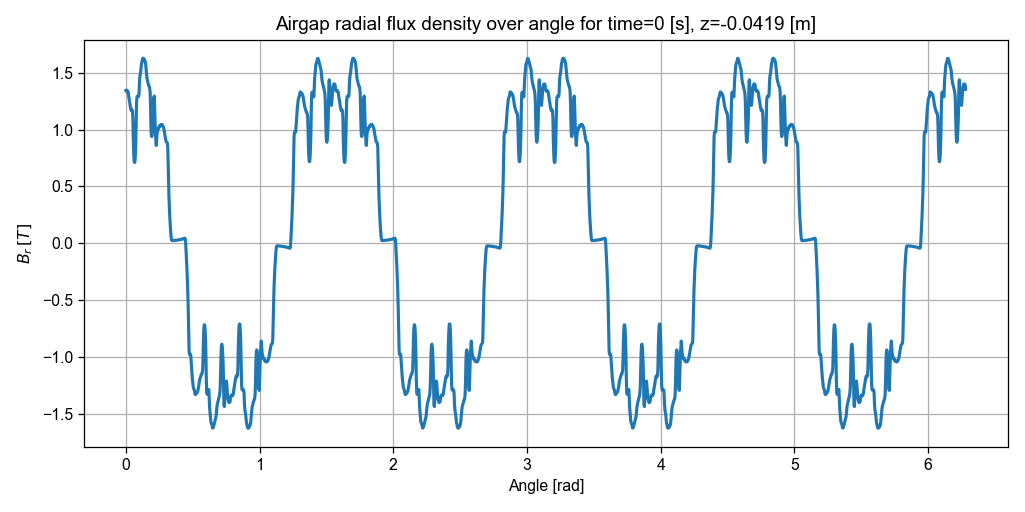

<IPython.core.display.Javascript object>


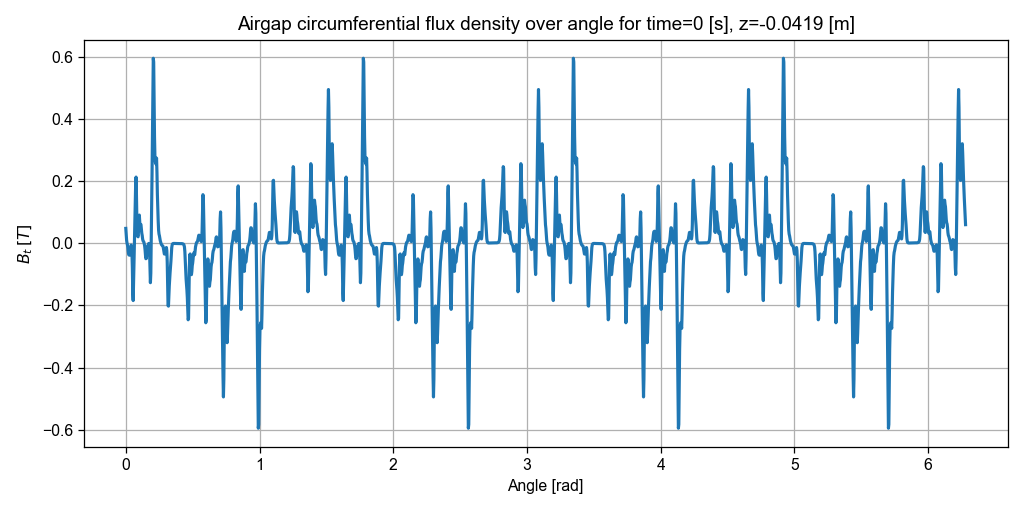

Index of the reference simulation in the list: None
Id: -135.4188051049254 , Iq: 113.62986941801093 , Tem_av_ref: None


<IPython.core.display.Javascript object>


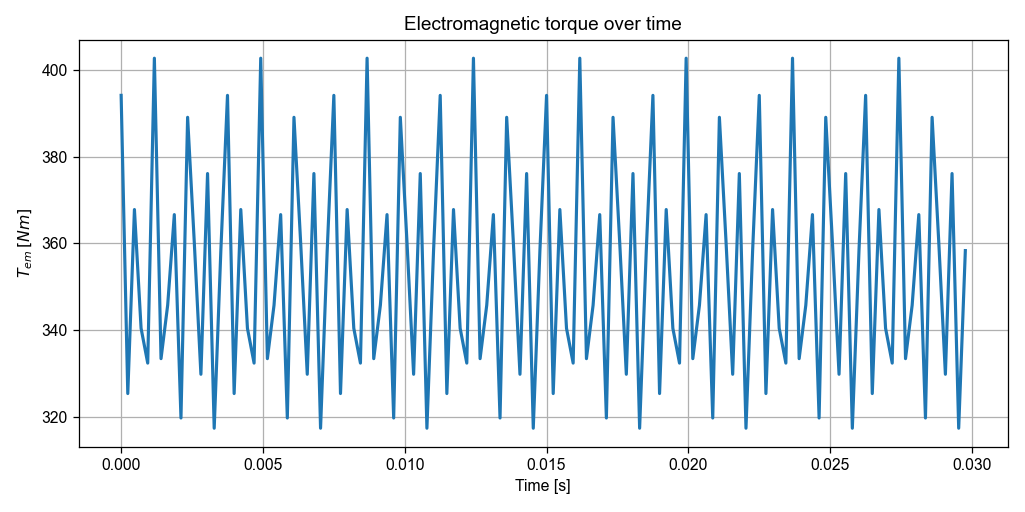

In [17]:
# Flux of the 3rd simulation
print("Id: "+str(Xout_vop.output_list[2].elec.OP.Id_ref)+" , Iq: "+str(Xout_vop.output_list[2].elec.OP.Iq_ref)+" , Tem_av_ref: "+str(Xout_vop.output_list[2].elec.Tem_av_ref))
Xout_vop.output_list[2].mag.B.plot_2D_Data("angle")

print("Index of the reference simulation in the list: "+str(Xout_vop.xoutput_ref_index))
print("Id: "+str(Xout_vop.output_list[8].elec.OP.Id_ref)+" , Iq: "+str(Xout_vop.output_list[8].elec.OP.Iq_ref)+" , Tem_av_ref: "+str(Xout_vop.output_list[8].elec.Tem_av_ref))
Xout_vop.output_list[8].mag.Tem.plot_2D_Data("time")

Any parameter in the xOutput_dict can be plot as a function of any other

<IPython.core.display.Javascript object>


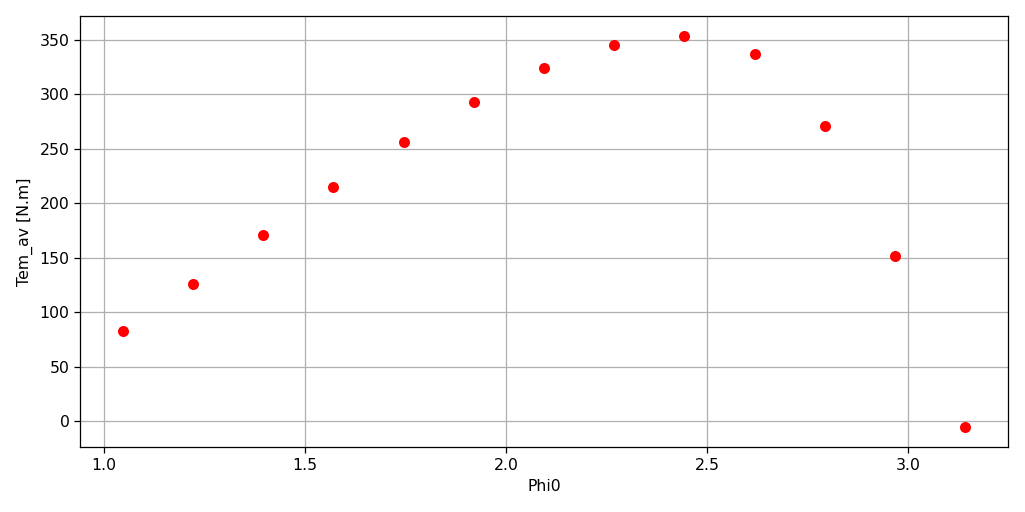

<IPython.core.display.Javascript object>


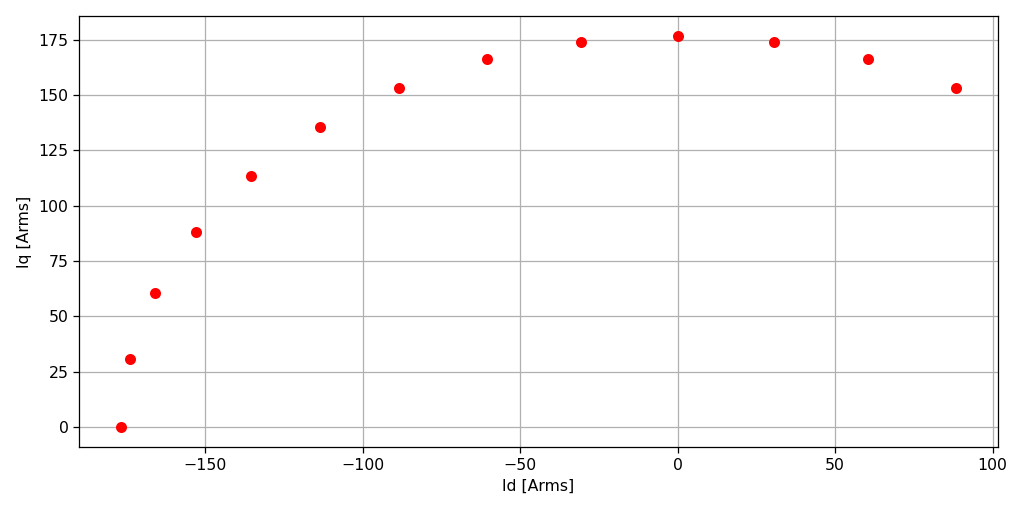

In [18]:
fig = Xout_vop.plot_multi("Phi0", "Tem_av")
fig = Xout_vop.plot_multi("Id", "Iq")

## Second multi-simulation layer only: Parameter Sweep

In pyleecan a Parameter Sweep is defined with a VarParam object. The design variables are set with ParamExplorer objects and the same Datakeeper as for a VarLoadCurrent (Id, Id, Tem_av...) will be automatically defined as output. Other Datakeepers can be defined in simu.var_simu.datakeeper_list.

VarParam and VarLoadCurrent inherit from the same class VarSimu. This is why most of the parameter of VarLoadCurrent are also available in VarParam and that both classes share the same behaviour. The main difference is how the simulation list is defined. Technically a VarLoadCurrent could be defined with a VarParam using ParamExplorer on Id / Iq / Tem_av_ref.

For this tutorial, only one ParamExplorer is defined: a linspace on the stator slot opening. The is_reuse_femm_file is desactivated as each simulation will have a different machine and is_keep_all_output is activated to show the full content of the xoutput object.

In [19]:
from pyleecan.Classes.VarParam import VarParam
from pyleecan.Classes.ParamExplorerInterval import ParamExplorerInterval

simu_sweep = simu_ref.copy()

# Multi-simulation to change machine parameters
sweep = VarParam(
    stop_if_error=True,
    is_reuse_femm_file=False,
    is_keep_all_output=True,
)
simu_sweep.var_simu = sweep
N_sweep = 8

# List of ParamExplorer to define multisimulation input values
simu_sweep.var_simu.paramexplorer_list = [
    ParamExplorerInterval(
        name="Stator slot opening",
        symbol="W0s",
        unit="m",
        setter="simu.machine.stator.slot.W0",
        getter="simu.machine.stator.slot.W0",
        min_value=0.1 * Toyota_Prius.stator.slot.W0,
        max_value=1.4 * Toyota_Prius.stator.slot.W0,
        N=N_sweep,
    )
]

print("Value used in the Parameter sweep: "+str(simu_sweep.var_simu.paramexplorer_list[0].get_value()))
print("Reference machine W0: "+str(Toyota_Prius.stator.slot.W0))

Value used in the Parameter sweep: [0.000193   0.00055143 0.00090986 0.00126829 0.00162671 0.00198514
 0.00234357 0.002702  ]
Reference machine W0: 0.00193


In [20]:
Xout_sweep = simu_sweep.run()

[16:49:15] Starting running simulation tuto_multi (machine=Toyota_Prius)
[16:49:15] Computing reference simulation for Parameter Sweep
[16:49:15] W0s: 8 values from 0.000193 to 0.002702 (ref=0.00193) [m]
[16:49:15] Starting Magnetic module
[16:49:17] Solving time step 1 / 16 in FEMM
[16:49:18] Solving time step 5 / 16 in FEMM
[16:49:19] Solving time step 13 / 16 in FEMM
[16:49:20] Solving time step 9 / 16 in FEMM
[16:49:20] Solving time step 2 / 16 in FEMM
[16:49:21] Solving time step 6 / 16 in FEMM
[16:49:23] Solving time step 14 / 16 in FEMM
[16:49:24] Solving time step 3 / 16 in FEMM
[16:49:25] Solving time step 10 / 16 in FEMM
[16:49:25] Solving time step 7 / 16 in FEMM
[16:49:26] Solving time step 15 / 16 in FEMM
[16:49:27] Solving time step 4 / 16 in FEMM
[16:49:27] Solving time step 11 / 16 in FEMM
[16:49:29] Solving time step 8 / 16 in FEMM
[16:49:30] Solving time step 16 / 16 in FEMM
[16:49:31] Solving time step 12 / 16 in FEMM
[16:49:35] Parameter Sweep Reference Results: N0=

[16:51:50] Parameter Sweep Results: N0=2000 [rpm], Id=-135.4 [Arms], Iq=113.6 [Arms], Tem_av=354.6 [N.m], Tem_rip_pp=88.36 [N.m], Tem_rip_norm=0.2492 [-], Pem_av=7.426e+04 [W]
[============================================      ]  88%
[16:51:50] Running simulation 8/8 with W0s=0.002702
[16:51:51] Starting Magnetic module
[16:51:53] Solving time step 1 / 16 in FEMM
[16:51:54] Solving time step 5 / 16 in FEMM
[16:51:55] Solving time step 13 / 16 in FEMM
[16:51:56] Solving time step 9 / 16 in FEMM
[16:51:58] Solving time step 6 / 16 in FEMM
[16:51:58] Solving time step 2 / 16 in FEMM
[16:52:01] Solving time step 14 / 16 in FEMM
[16:52:01] Solving time step 10 / 16 in FEMM
[16:52:03] Solving time step 7 / 16 in FEMM
[16:52:03] Solving time step 3 / 16 in FEMM
[16:52:04] Solving time step 15 / 16 in FEMM
[16:52:05] Solving time step 11 / 16 in FEMM
[16:52:05] Solving time step 8 / 16 in FEMM
[16:52:06] Solving time step 4 / 16 in FEMM
[16:52:07] Solving time step 12 / 16 in FEMM
[16:52:07] S

The log of the simulation enables to understand step by step the status of the computation. As expected, the reference simulation is computed first (which is still on a single operating point). Then, each of the 8 simulations (ref W0s in not in the value list) is run on the same operating point with a different value for the stator slot opening displayed as:

**Running simulation 7/8 with W0s=0.0020127143**

And ending with the datakeepers result for this simulation:

**Parameter Sweep Results: N0=2000 [rpm], Id=-135.4 [Arms], Iq=113.6 [Arms], Tem_av=353.8 [N.m], Tem_rip_pp=82.94 [N.m], Tem_rip_norm=0.2344 [-]**
    
When is_keep_all_output is True, the reference output is either stored in the output_list if one of the N simulation matches the reference one or in xoutput_ref otherwise

In [21]:
print("Xout_sweep.xoutput_ref:" +str(type(Xout_sweep.xoutput_ref)))
print("Xout_sweep.xoutput_ref_index:" +str(Xout_sweep.xoutput_ref_index))
print("\nXout_vop.xoutput_ref:" +str(Xout_vop.xoutput_ref))
print("Xout_vop.xoutput_ref_index:" +str(Xout_vop.xoutput_ref_index))

# A function enables to acces the reference output in all the cases
xoutput_ref = Xout_sweep.get_xoutput_ref()

Xout_sweep.xoutput_ref:<class 'pyleecan.Classes.Output.Output'>
Xout_sweep.xoutput_ref_index:None

Xout_vop.xoutput_ref:parent = <class 'pyleecan.Classes.XOutput.XOutput'> object
simu = parent = <class 'pyleecan.Classes.Output.Output'> object
	name = "tuto_multi"
	desc = ""
	machine = parent = <class 'pyleecan.Classes.Simu1.Simu1'> object
		frame = None
		
		shaft = parent = <class 'pyleecan.Classes.MachineIPMSM.MachineIPMSM'> object
			Lshaft = 0.1
			mat_type = parent = <class 'pyleecan.Classes.Shaft.Shaft'> object
				name = "M400-50A"
				is_isotropic = False
				elec = parent = <class 'pyleecan.Classes.Material.Material'> object
					rho = 1
					epsr = 1
					alpha = 1
				mag = parent = <class 'pyleecan.Classes.Material.Material'> object
					mur_lin = 2500.0
					Hc = 0
					Brm20 = 0
					alpha_Br = 0
					Wlam = 0.0005
					BH_curve = parent = <class 'pyleecan.Classes.MatMagnetics.MatMagnetics'> object
						is_transpose = False
						value = 
						[[0.000e+00 0.000e+00]
 [1

output_list, xoutput_dict and the respective plot commands work the same way as for VarLoadCurrent. The ParamExplorer are also available for plot_multi:

<IPython.core.display.Javascript object>


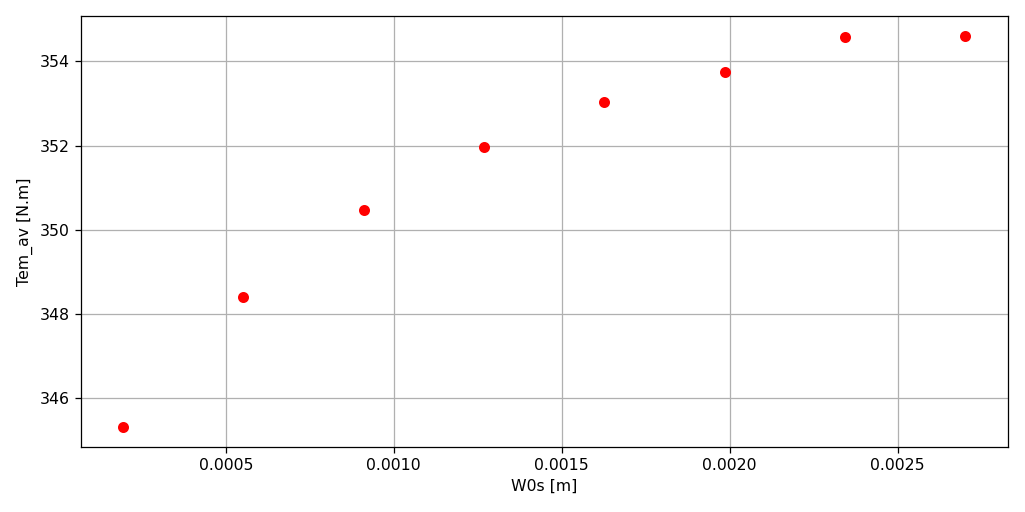

In [22]:
Xout_sweep.plot_multi("W0s","Tem_av")

As a reminder, each output contains the simulation that computed it. Using Parameter sweep with is_keep_all_output enables to access each generated simulation and machine in the output_list. The following code will extract the machine with the highest torque. To get the corresponding W0s, the ParamExplorerInterval was converted to a ParamExplorerSet to store the actual values used during the simulation. 

In [23]:
from numpy import argmax, max as np_max
# Find the simulation with the most torque
Tmax = np_max(Xout_sweep.xoutput_dict["Tem_av"].result)
Tmax_id = int(argmax(Xout_sweep.xoutput_dict["Tem_av"].result))
print("Max Torque is "+str(Tmax)+" [N.m], for simulation index "+str(Tmax_id))

# Find the corresponding W0s
print(type(Xout_sweep.paramexplorer_list[0]))
W0s_val = Xout_sweep.paramexplorer_list[0].get_value()
print(W0s_val)

print("Corresponding W0s is " + str(W0s_val[Tmax_id]))

# To save the simulation or machine for further modifications/computations
# Xout_sweep.output_list[Tmax_id].simu.save(path/to/json/file)
# Xout_sweep.output_list[Tmax_id].simu.machine.save(path/to/json/file)

Max Torque is 354.6024461757492 [N.m], for simulation index 7
<class 'pyleecan.Classes.ParamExplorerSet.ParamExplorerSet'>
[0.00019300000000000003, 0.0005514285714285714, 0.0009098571428571429, 0.0012682857142857144, 0.0016267142857142858, 0.001985142857142857, 0.002343571428571429, 0.002702]
Corresponding W0s is 0.002702


It is also possible to access the machine plot command to check the modifications:

<IPython.core.display.Javascript object>


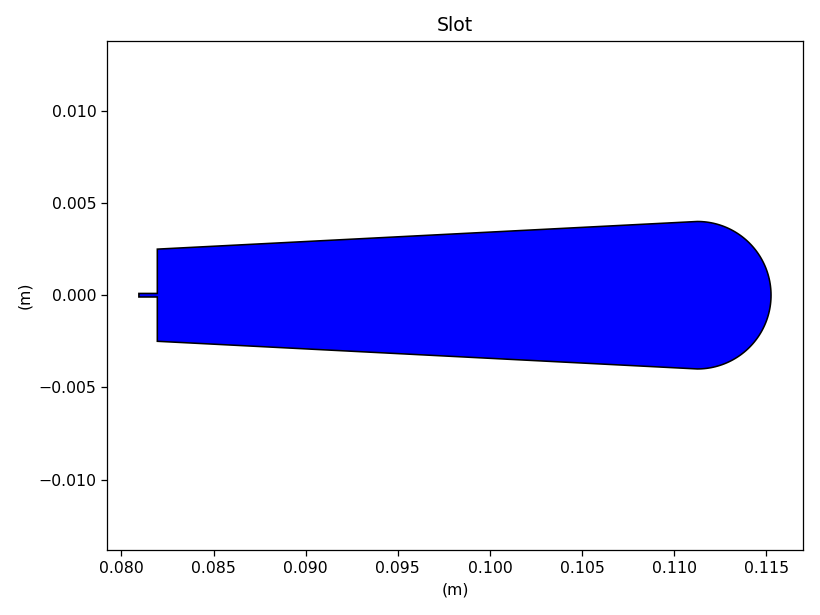

<IPython.core.display.Javascript object>


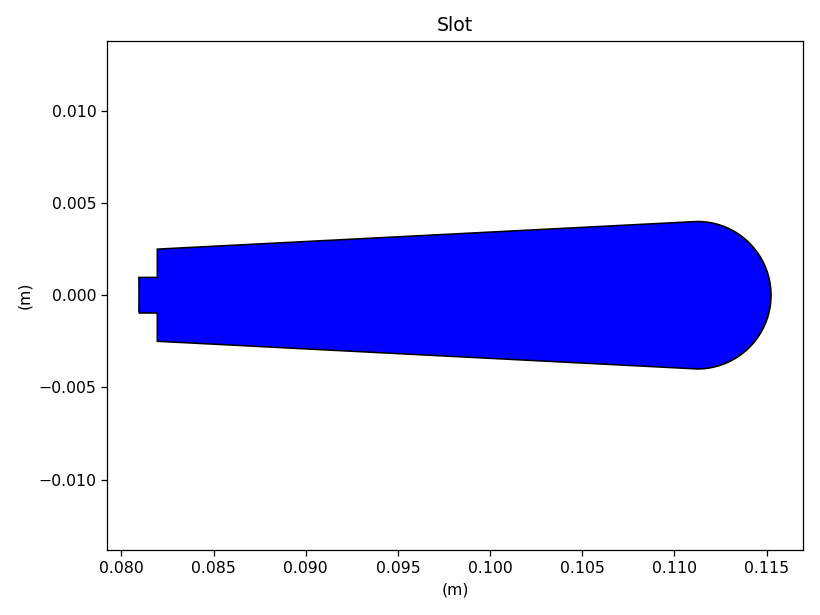

<IPython.core.display.Javascript object>


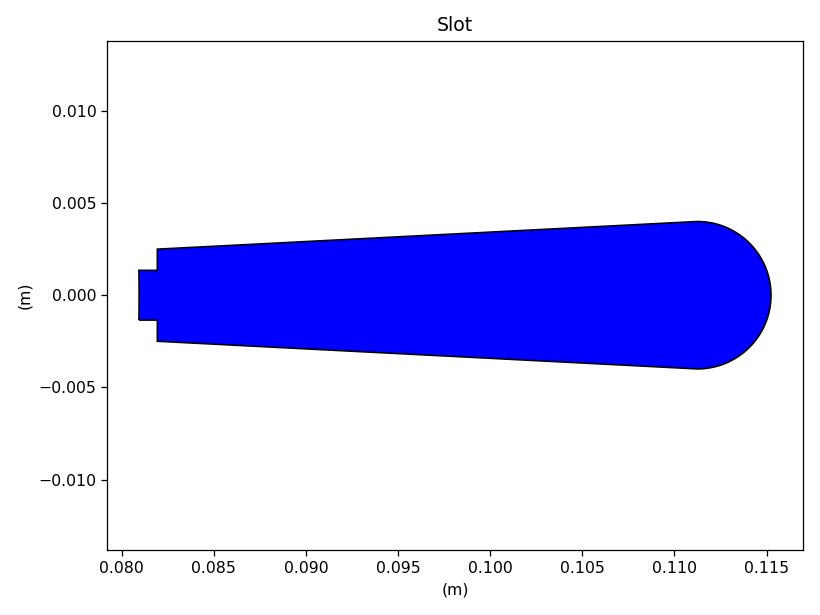

In [24]:
Xout_sweep.output_list[0].simu.machine.stator.slot.plot()
Xout_sweep.xoutput_ref.simu.machine.stator.slot.plot()
Xout_sweep.output_list[-1].simu.machine.stator.slot.plot()

## Both multi-simulation layers: Parameter-sweep of variable speed simulation

For now, we have set the var_simu property of Simulation with a VarSimu object to define a multi-simulation. To define a multi-simulation of multi-simulation, we can use the var_simu property of VarSimu which also take a VarSimu object. This definition principal has no limit in the number of "simulation layer" but no usage should require more than two layers.

In [25]:
multi_simu = simu_ref.copy()
multi_simu.var_simu = sweep.copy()
multi_simu.var_simu.var_simu = varload.copy()

The workflow of this simulation is the following:
- Pyleecan checks simu.var_simu => VarParam.run
- VarParam defines its reference simulation with simu.var_simu = simu.var_simu.var_simu
- VarParam run its referencece simulation, check simu.var_simu => VarLoadCurrent.run
- The reference simulation of VarParam is a VarLoadCurrent simulation that defines its own reference simulation with simu.var_simu = simu.var_simu.var_simu (which is None)
- When running the reference simulation of VarLoadCurrent, simu.var_simu is None so we run the models (this simulation is then exaclty simu_ref defined previously)
- Pyleecan run the N_speed simulations of the VarLoadCurrent
- Pyleecan generates the N_sweep simulations of the VarParam which are VarLoadCurrent and run them all
- For each VarLoadCurrent simulation, a reference simulation is defined then the N_speed simulations

So this simulation will run (1+N_sweep) * (1+N_speed) simulations. This is why it is important to make sure that the reference simulation is part of the N simulations to skip one computation on both sides.

Each simulation layer has its own properties which enables to do the following:

In [26]:
# VarParam => All machine are different
multi_simu.var_simu.is_reuse_femm_file = False
# VarLoadCurrent => All machines are the same
multi_simu.var_simu.var_simu.is_reuse_femm_file = True

To explain the output structure, this tutorial will again use the is_keep_all_output option. To speed up the computation and reduce the memory usage the number of simulation is reduced:

In [27]:
# VarParam
multi_simu.var_simu.is_keep_all_output = True
multi_simu.var_simu.datakeeper_list = list()  # reset datakeeper list
multi_simu.var_simu.paramexplorer_list[0].N = 4
multi_simu.var_simu.paramexplorer_list[0].max_value = Toyota_Prius.stator.slot.W0  # Ref is in the N simu
# VarLoadCurrent
multi_simu.var_simu.var_simu.is_keep_all_output = True
multi_simu.var_simu.var_simu.datakeeper_list = list()  # reset datakeeper list
multi_simu.var_simu.var_simu.OP_matrix = OP_matrix[:-4, :]
print("OP matrix")
print(multi_simu.var_simu.var_simu.OP_matrix)
# Reference simulation
multi_simu.input.Nt_tot = 64

OP matrix
[[2.00000000e+03 1.76776695e+02 1.04719755e+00 7.90000000e+01]
 [2.00000000e+03 1.76776695e+02 1.22173048e+00 1.25000000e+02]
 [2.00000000e+03 1.76776695e+02 1.39626340e+00 1.60000000e+02]
 [2.00000000e+03 1.76776695e+02 1.57079633e+00 1.92000000e+02]
 [2.00000000e+03 1.76776695e+02 1.74532925e+00 2.37000000e+02]
 [2.00000000e+03 1.76776695e+02 1.91986218e+00 2.81000000e+02]
 [2.00000000e+03 1.76776695e+02 2.09439510e+00 3.19000000e+02]
 [2.00000000e+03 1.76776695e+02 2.26892803e+00 3.43000000e+02]
 [2.00000000e+03 1.76776695e+02 2.44346095e+00 3.53000000e+02]]


For a better understanding of the logs, the VarLoadCurrent simulation log can be filtered with:

In [28]:
multi_simu.layer_log_warn = 2

In [29]:
Xout_multi = multi_simu.run()

[16:52:52] Starting running simulation tuto_multi (machine=Toyota_Prius)
[16:52:52] Computing reference simulation for Parameter Sweep
[16:52:52] W0s: 4 values from 0.000193 to 0.00193 (ref=0.00193) [m]
[16:52:52] Reference Operating point is not in OP_matrix, one extra simulation will be computed
[16:52:52]     Computing reference simulation for Variable Load
[16:53:06]     Variable Load Reference Results: N0=2000 [rpm], Id=-135.4 [Arms], Iq=113.6 [Arms], I0=176.8 [A], Phi0=2.443 [], Tem_av_ref=None [N.m], Tem_av=353.8 [N.m], Tem_rip_pp=76.83 [N.m], Tem_rip_norm=0.2171 [-], Pem_av=7.41e+04 [W]
               [=====                                             ]  10%
[16:53:06]     Variable Load: Using same FEMM file for all simulation (D:\GitHub\pyleecan-public\pyleecan\Results\tuto_multi\Femm\Toyota_Prius_model.fem)
[16:53:06]     Running simulation 1/9 with N0=2000 [rpm], Id=88.39 [Arms], Iq=153.1 [Arms]
[16:53:19]     Variable Load Results: N0=2000 [rpm], Id=88.39 [Arms], Iq=153.1 [

               [=============================================     ]  90%
[16:55:51]     Running simulation 9/9 with N0=2000 [rpm], Id=-135.4 [Arms], Iq=113.6 [Arms]
[16:55:59]     Variable Load Results: N0=2000 [rpm], Id=-135.4 [Arms], Iq=113.6 [Arms], I0=176.8 [A], Phi0=2.443 [], Tem_av_ref=None [N.m], Tem_av=345 [N.m], Tem_rip_pp=81.17 [N.m], Tem_rip_norm=0.2353 [-], Pem_av=7.226e+04 [W]
               [==================================================] 100%
[16:55:59] Parameter Sweep Results: Max_Tem_av=345 [N.m], Max_Tem_rip_pp=91.1 [N.m], Max_Tem_rip_norm=0.314 [-]
[====================                              ]  40%
[16:55:59] Running simulation 2/4 with W0s=0.000772
[16:56:00] Reference Operating point is not in OP_matrix, one extra simulation will be computed
[16:56:00]     Computing reference simulation for Variable Load
[16:56:09]     Variable Load Reference Results: N0=2000 [rpm], Id=-135.4 [Arms], Iq=113.6 [Arms], I0=176.8 [A], Phi0=2.443 [], Tem_av_ref=None [N.m], Te

               [========================================          ]  80%
[16:58:24]     Running simulation 8/9 with N0=2000 [rpm], Id=-113.6 [Arms], Iq=135.4 [Arms]
[16:58:33]     Variable Load Results: N0=2000 [rpm], Id=-113.6 [Arms], Iq=135.4 [Arms], I0=176.8 [A], Phi0=2.269 [], Tem_av_ref=None [N.m], Tem_av=344.1 [N.m], Tem_rip_pp=85.27 [N.m], Tem_rip_norm=0.2478 [-], Pem_av=7.207e+04 [W]
               [=============================================     ]  90%
[16:58:33]     Running simulation 9/9 with N0=2000 [rpm], Id=-135.4 [Arms], Iq=113.6 [Arms]
[16:58:41]     Variable Load Results: N0=2000 [rpm], Id=-135.4 [Arms], Iq=113.6 [Arms], I0=176.8 [A], Phi0=2.443 [], Tem_av_ref=None [N.m], Tem_av=352.2 [N.m], Tem_rip_pp=75.73 [N.m], Tem_rip_norm=0.215 [-], Pem_av=7.377e+04 [W]
               [==================================================] 100%
[16:58:41] Parameter Sweep Results: Max_Tem_av=352.2 [N.m], Max_Tem_rip_pp=85.27 [N.m], Max_Tem_rip_norm=0.3043 [-]
[=====================

Again, the logs enable to follow step by step each layer of the simulation with their corresponding input and output.
The datakeeper of the VarLoadCurrent are the same as previously:
**Variable Load Results: N0=2000 [rpm], Id=-135.4 [Arms], Iq=113.6 [Arms], I0=176.8 [A], Phi0=2.443 [], Tem_av_ref=353 [N.m], Tem_av=353.3 [N.m], Tem_rip_pp=73.53 [N.m], Tem_rip_norm=0.2081 [-]**

But the VarParam Datakeeper are now:

**Parameter Sweep Results: Max_Tem_av=345 [N.m], Max_Tem_rip_pp=90.72 [N.m], Max_Tem_rip_norm=0.3105 [-]**

The reason is that now the parameter sweep is running on a multi-simulation. Thus, Tem_av is now an array as a function of the operating point. So instead of storing Tem_av, the datakeeper now store the maximum of the Tem_av DataKeeper of the VarLoadCurrent simulation ("max(output.xoutput_dict['Tem_av'].result)")

The xoutput_dict contains only the information related to the VarParm:

Values available in XOutput:
dict_keys(['Max_Tem_av', 'Max_Tem_rip_pp', 'Max_Tem_rip_norm'])

Maximum Torque for each Design:
[345.0304985573581, 349.7642780183083, 352.22143610291545, 353.80472945261613]
W0s for each Design:
[0.00019300000000000003, 0.000772, 0.001351, 0.00193]


<IPython.core.display.Javascript object>


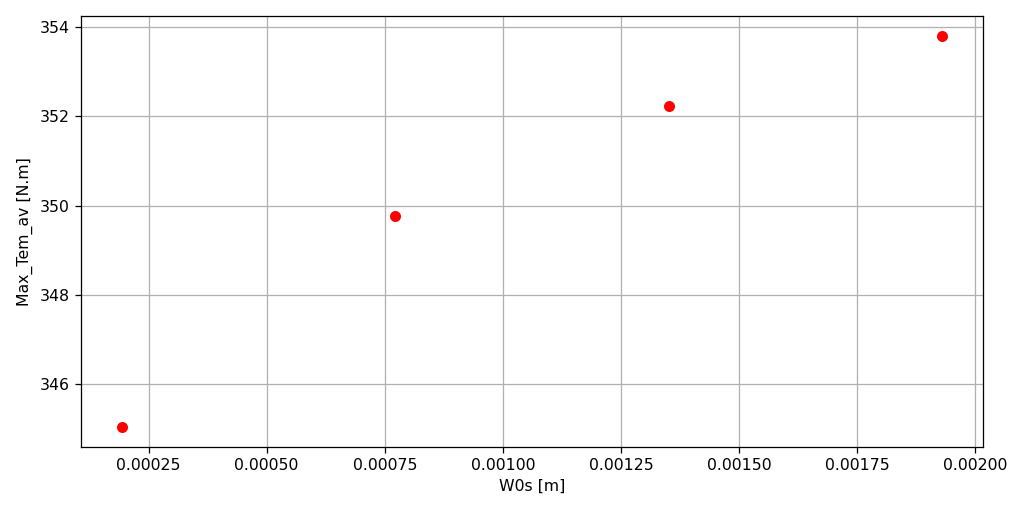

In [30]:
print("Values available in XOutput:")
print(Xout_multi.xoutput_dict.keys())

print("\nMaximum Torque for each Design:")
print(Xout_multi.xoutput_dict["Max_Tem_av"].result)
print("W0s for each Design:")
print(Xout_multi.paramexplorer_list[0].get_value())

Xout_multi.plot_multi("W0s", "Max_Tem_av")

In [31]:
Xout_multi.xoutput_dict["Max_Tem_av"].result

[345.0304985573581, 349.7642780183083, 352.22143610291545, 353.80472945261613]

As the is_keep_all_output option was activated, output_list is available but now it contains the xouput resulting from the VarLoadCurrent computation. Then all the VarLoadCurrent DataKeeper are available.

In [32]:
print(type(Xout_multi.output_list[0]))
print(type(Xout_sweep.output_list[0]))

print("\nDatakeeper of VarLoadCurrent simulation of Design 0")
print(Xout_multi.output_list[0].xoutput_dict.keys())
print("Average torque for each operating point of Design 0")
print(Xout_multi.output_list[0].xoutput_dict["Tem_av"].result)

# To save the VarLoadCurrent simulation or machine for further modifications/computations
# Xout_multi.output_list[0].simu.save(path/to/json/file)
# Xout_multi.output_list[0].simu.machine.save(path/to/json/file)

<class 'pyleecan.Classes.XOutput.XOutput'>
<class 'pyleecan.Classes.Output.Output'>

Datakeeper of VarLoadCurrent simulation of Design 0
dict_keys(['N0', 'Id', 'Iq', 'I0', 'Phi0', 'Tem_av_ref', 'Tem_av', 'Tem_rip_pp', 'Tem_rip_norm', 'Pem_av'])
Average torque for each operating point of Design 0
[80.94610281890381, 123.5638043502944, 167.40952551307998, 210.67150583907878, 251.3183718014907, 287.2531533915088, 316.82132486878527, 337.65567569144696, 345.0304985573581]


As the VarLoadCurrent also have the is_keep_all_output option activated, the output of each simulation is available and  it is possible to call the corresponding plot command

<IPython.core.display.Javascript object>


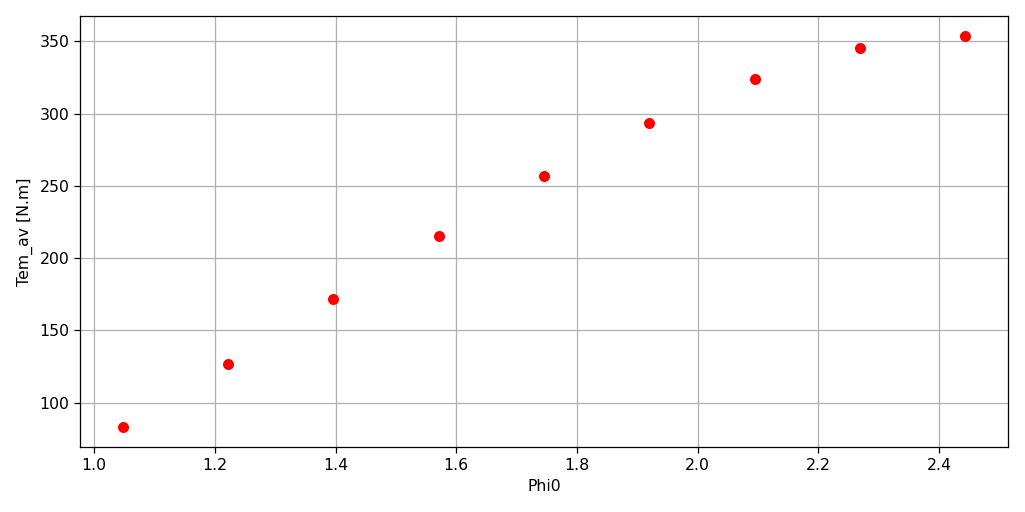

<IPython.core.display.Javascript object>


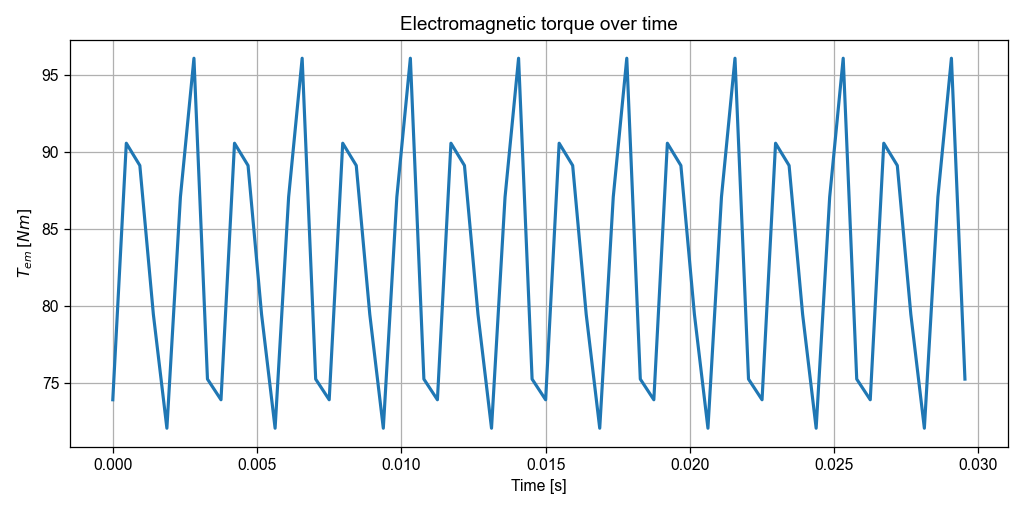

<IPython.core.display.Javascript object>


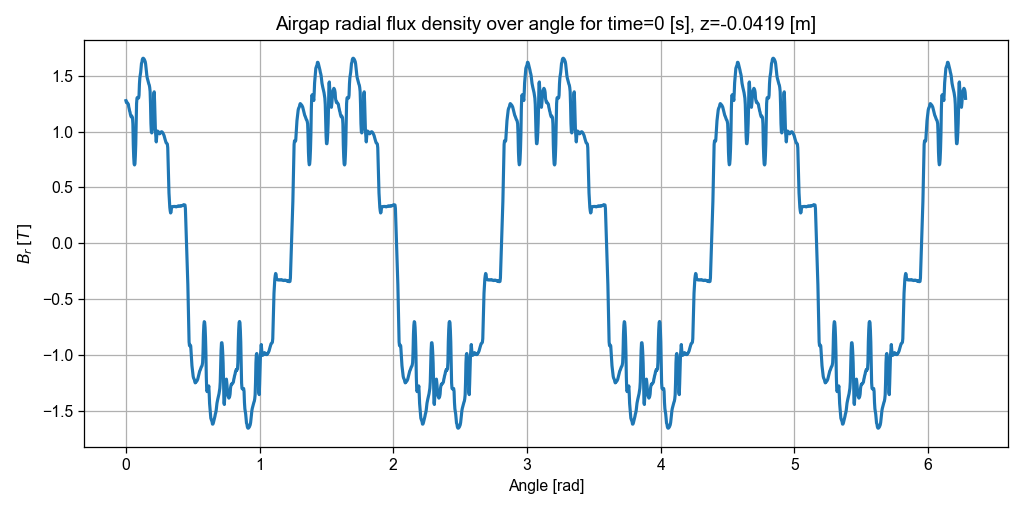

<IPython.core.display.Javascript object>


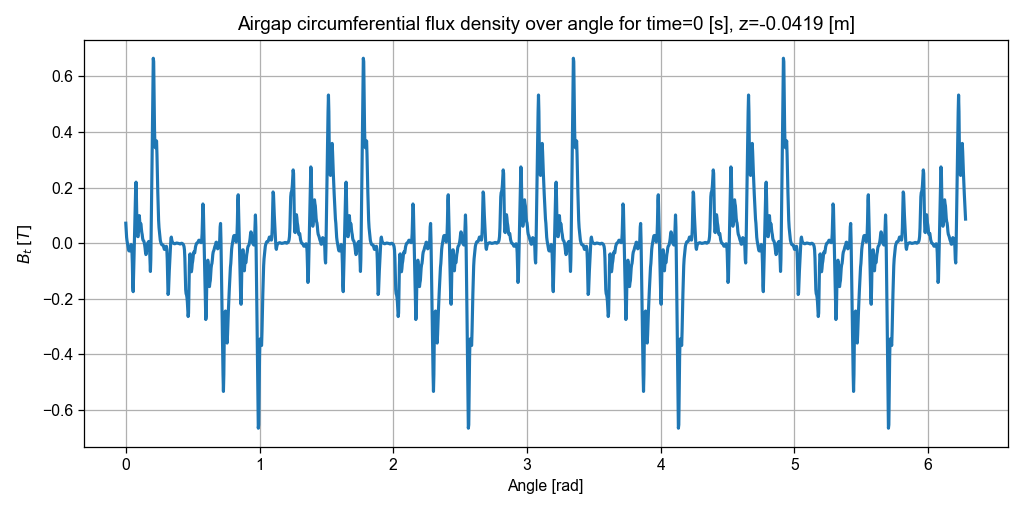

In [33]:
Xout_multi.output_list[-1].plot_multi("Phi0", "Tem_av")
# Torque at the first Operating point for the Last design
Xout_multi.output_list[-1].output_list[0].mag.Tem.plot_2D_Data("time")
# Flux of the 4th Operating point for the Last design
Xout_multi.output_list[-1].output_list[3].mag.B.plot_2D_Data("angle")
